In [30]:
# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from data_utils import *
from eval_utils import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from lstm import LSTMModel
from cnnlstm import CNNLSTMModel
from lstmattn import LSTMAttentionModel
from transformer import TransformerModel

In [31]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [32]:
data_dir = '../data/'

test_data = np.load(data_dir + 'test_data.npz')

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 
                 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']
muscle_titles = ['Tibialis Posterior', 'Tibialis Anterior', 'Extensor Digitorum Longus', 'Extensor Hallucis Longus', 
                 'Flexor Digitorum Longus', 'Flexor Hallucis Longus', 'Peroneus Brevis', 'Peroneus Longus', 'Achilles']
muscle_abbrevs = ['Tib Post', 'Tib Ant', 'EDL', 'EHL', 'FDL', 'FHL', 'Per Brevis', 'Per Long', 'Achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [33]:
X_test = test_data['X_test']
y_test = test_data['y_test']

print(X_test.shape, y_test.shape)

(1340, 100, 3) (1340, 100, 9)


In [34]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [35]:
lstm_model = LSTMModel(input_size=3, 
                       hidden_size=256, 
                       num_layers=2, 
                       output_size=9, 
                       dropout=0.08941182342943683)

lstm_model.load_state_dict(torch.load('../models/lstm.pth', weights_only=True))

lstm_model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(lstm_model.parameters(), 
#                        lr=0.0004070688993179255, 
#                        weight_decay=4.278679617413207e-05)

LSTMModel(
  (lstm): LSTM(3, 256, num_layers=2, batch_first=True, dropout=0.08941182342943683)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [36]:
lstm_loss, lstm_pred_tensor = eval_model(lstm_model, X_test_tensor, y_test_tensor)
print(f"LSTM Loss: {lstm_loss}")

LSTM Loss: 1532.4637451171875


In [37]:
# y_test = y_test_tensor.cpu().numpy()
lstm_pred = lstm_pred_tensor.cpu().numpy()

lstm_rrmse = calc_rrmse_muscle(y_test, lstm_pred)

tibpost: 0.0755
tibant: 0.0343
edl: 0.0521
ehl: 0.0307
fdl: 0.0676
fhl: 0.0790
perbrev: 0.0532
perlong: 0.0465
achilles: 0.0222


In [38]:
lstm_r2 = calc_r2_muscle(y_test, lstm_pred)

tibpost: 0.8238
tibant: 0.9358
edl: 0.8328
ehl: 0.9285
fdl: 0.8103
fhl: 0.7824
perbrev: 0.7212
perlong: 0.6422
achilles: 0.9910


In [39]:
cnnlstm_model = CNNLSTMModel(input_size=3, 
                             hidden_size=256,
                             num_layers=3, 
                             output_size=9, 
                             dropout=0.17575462419723403)

cnnlstm_model.load_state_dict(torch.load('../models/cnn-lstm.pth', weights_only=True))

cnnlstm_model.to(device)

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.17575462419723403)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [40]:
cnnlstm_loss, cnnlstm_pred_tensor = eval_model(cnnlstm_model, X_test_tensor, y_test_tensor)
print(f"CNN-LSTM Loss: {cnnlstm_loss}")

CNN-LSTM Loss: 1332.1439208984375


In [41]:
# y_test = y_test_tensor.cpu().numpy()
cnnlstm_pred = cnnlstm_pred_tensor.cpu().numpy()

cnnlstm_rrmse = calc_rrmse_muscle(y_test, cnnlstm_pred)

tibpost: 0.0716
tibant: 0.0302
edl: 0.0404
ehl: 0.0252
fdl: 0.0641
fhl: 0.0751
perbrev: 0.0467
perlong: 0.0409
achilles: 0.0207


In [42]:
cnnlstm_r2 = calc_r2_muscle(y_test, cnnlstm_pred)

tibpost: 0.8417
tibant: 0.9505
edl: 0.8995
ehl: 0.9518
fdl: 0.8298
fhl: 0.8032
perbrev: 0.7851
perlong: 0.7236
achilles: 0.9922


In [43]:
lstmattn_model = LSTMAttentionModel(input_size=3, 
                                    hidden_size=256, 
                                    num_layers=3, 
                                    num_heads=8, 
                                    output_size=9, 
                                    lstm_dropout=0.08509082023364795, 
                                    attn_dropout=0.3104457129518861)

lstmattn_model.load_state_dict(torch.load('../models/lstm-attn.pth', weights_only=True))

lstmattn_model.to(device)

LSTMAttentionModel(
  (lstm): LSTM(3, 256, num_layers=3, batch_first=True, dropout=0.08509082023364795)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [44]:
lstmattn_loss, lstmattn_pred_tensor = eval_model(lstmattn_model, X_test_tensor, y_test_tensor)
print(f"LSTM-Attention Loss: {lstmattn_loss}")

LSTM-Attention Loss: 979.1588134765625


In [45]:
lstmattn_pred = lstmattn_pred_tensor.cpu().numpy()

lstmattn_rrmse = calc_rrmse_muscle(y_test, lstmattn_pred)

tibpost: 0.0637
tibant: 0.0268
edl: 0.0385
ehl: 0.0282
fdl: 0.0657
fhl: 0.0683
perbrev: 0.0473
perlong: 0.0408
achilles: 0.0169


In [46]:
lstmattn_r2= calc_r2_muscle(y_test, lstmattn_pred)

tibpost: 0.8747
tibant: 0.9608
edl: 0.9087
ehl: 0.9396
fdl: 0.8208
fhl: 0.8372
perbrev: 0.7796
perlong: 0.7248
achilles: 0.9948


In [47]:
transformer_model = TransformerModel(input_dim=3,
                                     output_dim=9, 
                                     d_model=32, 
                                     nhead=8, 
                                     num_encoder_layers=6, 
                                     dim_feedforward=256, 
                                     dropout=0.012122943820592716)

transformer_model.load_state_dict(torch.load('../models/transformer.pth', weights_only=True))

transformer_model.to(device)

TransformerModel(
  (input_embedding): Linear(in_features=3, out_features=32, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=256, bias=True)
        (dropout): Dropout(p=0.012122943820592716, inplace=False)
        (linear2): Linear(in_features=256, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.012122943820592716, inplace=False)
        (dropout2): Dropout(p=0.012122943820592716, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=32, out_features=9, bias=True)
)

In [48]:
transformer_loss, transformer_pred_tensor = eval_model(transformer_model, X_test_tensor, y_test_tensor)
print(f"Transformer Loss: {transformer_loss}")

Transformer Loss: 890.1572265625


In [49]:
transformer_pred = transformer_pred_tensor.cpu().numpy()

transformer_rrmse = calc_rrmse_muscle(y_test, transformer_pred)

tibpost: 0.0574
tibant: 0.0251
edl: 0.0313
ehl: 0.0244
fdl: 0.0534
fhl: 0.0607
perbrev: 0.0431
perlong: 0.0361
achilles: 0.0170


In [50]:
transformer_r2 = calc_r2_muscle(y_test, transformer_pred)

tibpost: 0.8982
tibant: 0.9659
edl: 0.9397
ehl: 0.9547
fdl: 0.8817
fhl: 0.8717
perbrev: 0.8169
perlong: 0.7846
achilles: 0.9947


In [51]:
lstm_rmse_overall = calc_rmse_overall(y_test, lstm_pred)
print(f"LSTM RMSE Overall: {lstm_rmse_overall}")

cnnlstm_rmse_overall = calc_rmse_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RMSE Overall: {cnnlstm_rmse_overall}")

lstmattn_rmse_overall = calc_rmse_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RMSE Overall: {lstmattn_rmse_overall}")

transformer_rmse_overall = calc_rmse_overall(y_test, transformer_pred)
print(f"Transformer RMSE Overall: {transformer_rmse_overall}")

LSTM RMSE Overall: 39.14669674978443
CNN-LSTM RMSE Overall: 36.4985483109693
LSTM-Attention RMSE Overall: 31.291513970788696
Transformer RMSE Overall: 29.835502999717793


In [52]:
lstm_rrmse_overall = calc_rrmse_overall(y_test, lstm_pred)
print(f"LSTM RRMSE Overall: {lstm_rrmse_overall}")

cnnlstm_rrmse_overall = calc_rrmse_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RRMSE Overall: {cnnlstm_rrmse_overall}")

lstmattn_rrmse_overall = calc_rrmse_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RRMSE Overall: {lstmattn_rrmse_overall}")

transformer_rrmse_overall = calc_rrmse_overall(y_test, transformer_pred)
print(f"Transformer RRMSE Overall: {transformer_rrmse_overall}")

LSTM RRMSE Overall: 0.010057357027142635
CNN-LSTM RRMSE Overall: 0.009377009091778693
LSTM-Attention RRMSE Overall: 0.008039246068080486
Transformer RRMSE Overall: 0.007665175625685436


In [53]:
lstm_rrmse_weighted = calc_rrmse_weighted(y_test, lstm_pred)
print(f"LSTM RRMSE Weighted: {lstm_rrmse_weighted}")

cnnlstm_rrmse_weighted = calc_rrmse_weighted(y_test, cnnlstm_pred)
print(f"CNN-LSTM RRMSE Weighted: {cnnlstm_rrmse_weighted}")

lstmattn_rrmse_weighted = calc_rrmse_weighted(y_test, lstmattn_pred)
print(f"LSTM-Attention RRMSE Weighted: {lstmattn_rrmse_weighted}")

transformer_rrmse_weighted = calc_rrmse_weighted(y_test, transformer_pred)
print(f"Transformer RRMSE Weighted: {transformer_rrmse_weighted}")

LSTM RRMSE Weighted: 0.03625416116910989
CNN-LSTM RRMSE Weighted: 0.033316735770125616
LSTM-Attention RRMSE Weighted: 0.029418558891816698
Transformer RRMSE Weighted: 0.027417547690643182


In [54]:
lstm_rmspe = calc_rmspe_overall(y_test, lstm_pred)
print(f"LSTM RMSPE: {lstm_rmspe}")

cnnlstm_rmspe = calc_rmspe_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM RMSPE: {cnnlstm_rmspe}")

lstmattn_rmspe = calc_rmspe_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention RMSPE: {lstmattn_rmspe}")

transformer_rmspe = calc_rmspe_overall(y_test, transformer_pred)
print(f"Transformer RMSPE: {transformer_rmspe}")

LSTM RMSPE: 0.44553660295398567
CNN-LSTM RMSPE: 0.4417319561893806
LSTM-Attention RMSPE: 0.4323462132624994
Transformer RMSPE: 0.3589254023390982


In [55]:
lstm_r2_overall = calc_r2_overall(y_test, lstm_pred)
print(f"LSTM R2: {lstm_r2_overall}")

cnnlstm_r2_overall = calc_r2_overall(y_test, cnnlstm_pred)
print(f"CNN-LSTM R2: {cnnlstm_r2_overall}")

lstmattn_r2_overall = calc_r2_overall(y_test, lstmattn_pred)
print(f"LSTM-Attention R2: {lstmattn_r2_overall}")

transformer_r2_overall = calc_r2_overall(y_test, transformer_pred)
print(f"Transformer R2: {transformer_r2_overall}")

LSTM R2: 0.9934200719615306
CNN-LSTM R2: 0.9942801836712054
LSTM-Attention R2: 0.9957957933691405
Transformer R2: 0.9961779388698756


In [56]:
from sklearn.metrics import r2_score

lstm_r2_overall = r2_score(y_test.flatten(), lstm_pred.flatten())
print(f"LSTM R2: {lstm_r2_overall}")

cnnlstm_r2_overall = r2_score(y_test.flatten(), cnnlstm_pred.flatten())
print(f"CNN-LSTM R2: {cnnlstm_r2_overall}")

lstmattn_r2_overall = r2_score(y_test.flatten(), lstmattn_pred.flatten())
print(f"LSTM-Attention R2: {lstmattn_r2_overall}")

transformer_r2_overall = r2_score(y_test.flatten(), transformer_pred.flatten())
print(f"Transformer R2: {transformer_r2_overall}")

LSTM R2: 0.9934200719615306
CNN-LSTM R2: 0.9942801836712054
LSTM-Attention R2: 0.9957957933691405
Transformer R2: 0.9961779388698756


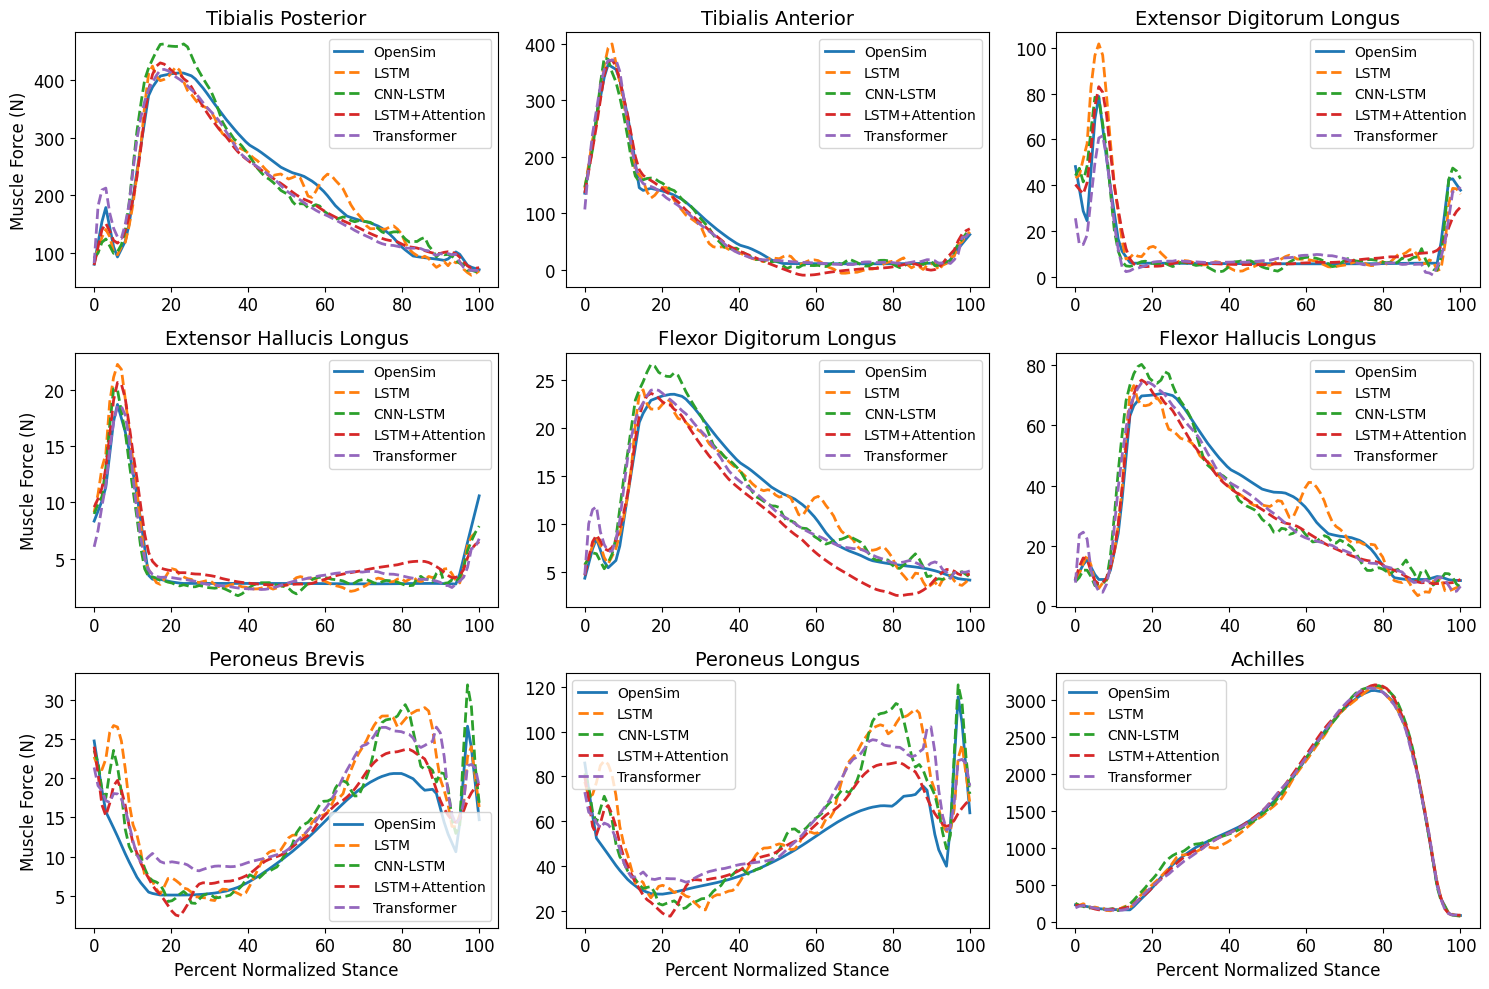

In [57]:
sample_idx = 0

preds = [lstm_pred[sample_idx], cnnlstm_pred[sample_idx], lstmattn_pred[sample_idx], transformer_pred[sample_idx]]
true = y_test[sample_idx]

perc_stance = np.linspace(0, 100, 100)

model_labels = ['LSTM', 'CNN-LSTM', 'LSTM+Attention', 'Transformer']

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(perc_stance, true[:, i], label='OpenSim', linewidth=2)
    
    for j, pred in enumerate(preds):
        ax.plot(perc_stance, pred[:, i], label=model_labels[j], linewidth=2, linestyle='--')
        
    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=12)
        
    if i % 3 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=12)
        
    ax.set_title(muscle_titles[i], fontsize=14)
    ax.legend()
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()


In [58]:
rrmse_muscle_dict = {'LSTM': lstm_rrmse, 'CNN-LSTM': cnnlstm_rrmse, 'LSTM+Attention': lstmattn_rrmse, 'Transformer': transformer_rrmse}
rrmse_overall_dict = {'LSTM': lstm_rrmse_weighted, 'CNN-LSTM': cnnlstm_rrmse_weighted, 'LSTM+Attention': lstmattn_rrmse_weighted, 'Transformer': transformer_rrmse_weighted}

rrmse_table = generate_latex_table(rrmse_muscle_dict, rrmse_overall_dict, muscle_titles)
print(rrmse_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 0.0755 & 0.0716 & 0.0637 & 0.0574 \\
{Tibialis Anterior} & 0.0343 & 0.0302 & 0.0268 & 0.0251 \\
{Extensor Digitorum Longus} & 0.0521 & 0.0404 & 0.0385 & 0.0313 \\
{Extensor Hallucis Longus} & 0.0307 & 0.0252 & 0.0282 & 0.0244 \\
{Flexor Digitorum Longus} & 0.0676 & 0.0641 & 0.0657 & 0.0534 \\
{Flexor Hallucis Longus} & 0.0790 & 0.0751 & 0.0683 & 0.0607 \\
{Peroneus Brevis} & 0.0532 & 0.0467 & 0.0473 & 0.0431 \\
{Peroneus Longus} & 0.0465 & 0.0409 & 0.0408 & 0.0361 \\
{Achilles} & 0.0222 & 0.0207 & 0.0169 & 0.0170 \\
\midrule
Overall & 0.0363 & 0.0333 & 0.0294 & 0.0274 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [59]:
r2_muscle_dict = {'LSTM': lstm_r2, 'CNN-LSTM': cnnlstm_r2, 'LSTM+Attention': lstmattn_r2, 'Transformer': transformer_r2}
r2_overall_dict = {'LSTM': lstm_r2_overall, 'CNN-LSTM': cnnlstm_r2_overall, 'LSTM+Attention': lstmattn_r2_overall, 'Transformer': transformer_r2_overall}

r2_table = generate_latex_table(r2_muscle_dict, r2_overall_dict, muscle_titles)
print(r2_table)

\begin{table}
\centering
\begin{tabular}{lcccc}
\toprule
\textbf{Muscle} & \textbf{LSTM} & \textbf{CNN-LSTM} & \textbf{LSTM+Attention} & \textbf{Transformer}\\
\midrule
{Tibialis Posterior} & 0.8238 & 0.8417 & 0.8747 & 0.8982 \\
{Tibialis Anterior} & 0.9358 & 0.9505 & 0.9608 & 0.9659 \\
{Extensor Digitorum Longus} & 0.8328 & 0.8995 & 0.9087 & 0.9397 \\
{Extensor Hallucis Longus} & 0.9285 & 0.9518 & 0.9396 & 0.9547 \\
{Flexor Digitorum Longus} & 0.8103 & 0.8298 & 0.8208 & 0.8817 \\
{Flexor Hallucis Longus} & 0.7824 & 0.8032 & 0.8372 & 0.8717 \\
{Peroneus Brevis} & 0.7212 & 0.7851 & 0.7796 & 0.8169 \\
{Peroneus Longus} & 0.6422 & 0.7236 & 0.7248 & 0.7846 \\
{Achilles} & 0.9910 & 0.9922 & 0.9948 & 0.9947 \\
\midrule
Overall & 0.9934 & 0.9943 & 0.9958 & 0.9962 \\
\bottomrule
\end{tabular}
\caption{Caption}
\label{tab:results}
\end{table}



In [60]:
# Settings
muscles = [muscle_abbrevs[i] for i in range(9)]  # Labels for muscles
muscles += ['Overall']  # Add overall R^2
models = list(r2_muscle_dict.keys())
x = np.arange(len(muscles))  # Muscle indices for the x-axis

bar_width = 0.2  # Width of each bar
offsets = np.arange(len(models)) * bar_width  # Offsets for grouped bars

colors = {
    'LSTM': 'C1',
    'CNN-LSTM': 'C2',
    'LSTM+Attention': 'C3',
    'Transformer': 	'C4'
}

for model in models:
    r2_muscle_dict[model] = list(r2_muscle_dict[model])  # Ensure it's a list
    r2_muscle_dict[model].append(r2_overall_dict[model])  # Append overall R^2

    rrmse_muscle_dict[model] = list(rrmse_muscle_dict[model])  # Ensure it's a list
    rrmse_muscle_dict[model].append(rrmse_overall_dict[model])  # Append overall RRMSE



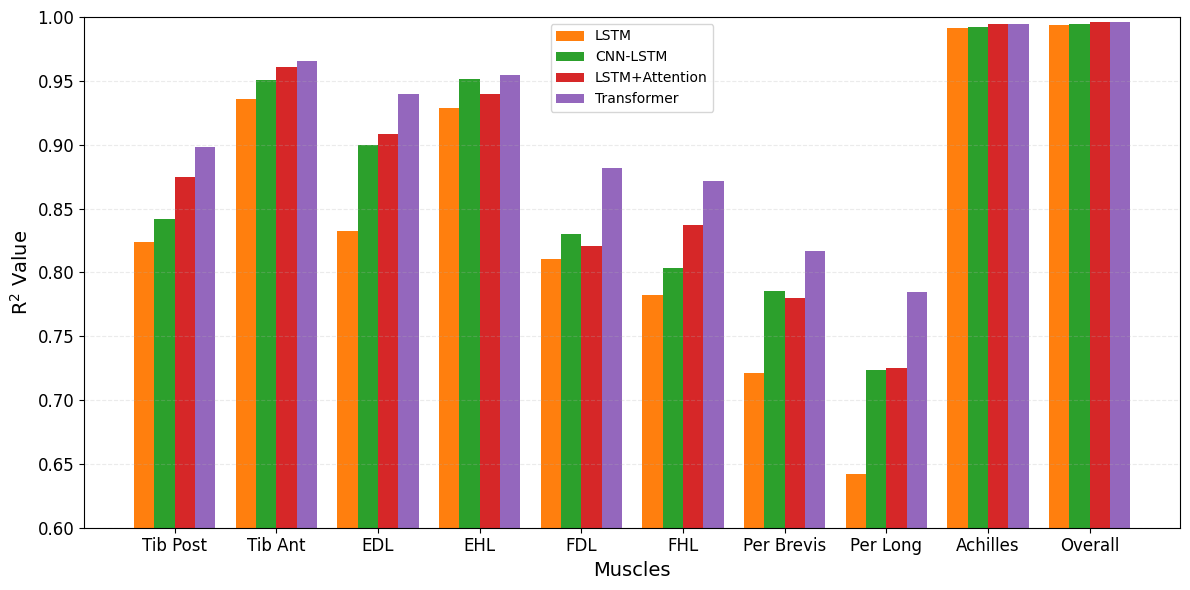

In [61]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], r2_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('R$^2$ Value', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()

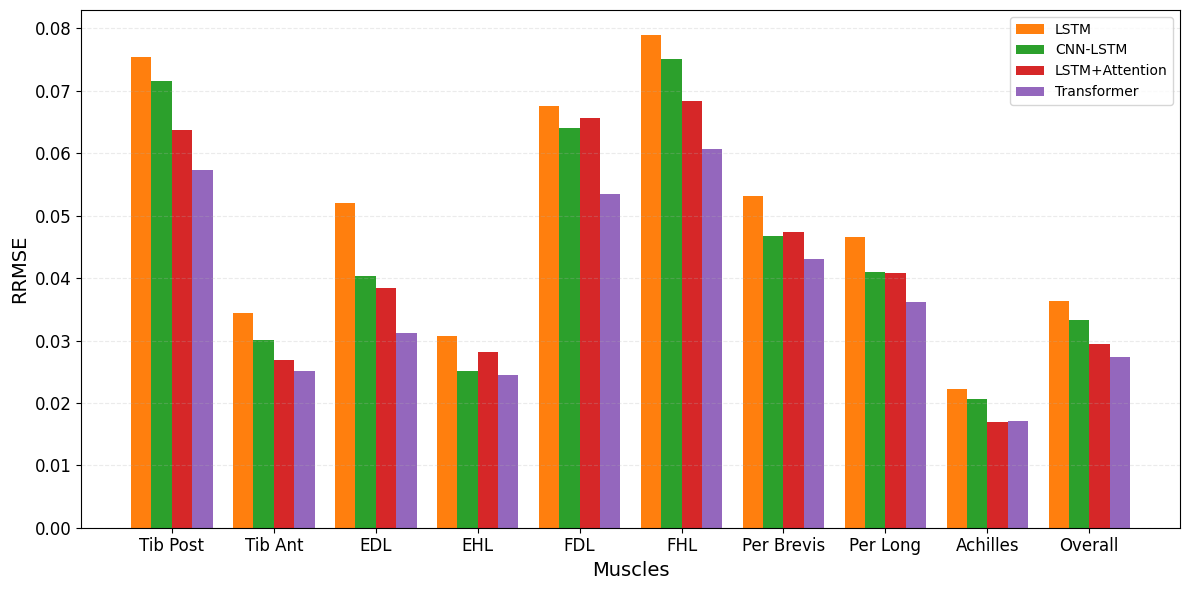

In [62]:
# Plotting
plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + offsets[i], rrmse_muscle_dict[model], width=bar_width, label=model, color=colors[model])

# Customize plot
plt.xlabel('Muscles', fontsize=14)
plt.ylabel('RRMSE', fontsize=14)
plt.xticks(x + bar_width * (len(models) - 1) / 2, muscles, fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(0.6, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)

# Show plot
plt.tight_layout()
plt.show()